In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.svm import SVC

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [0]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# !unzip UCI\ HAR\ Dataset.zip

In [0]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

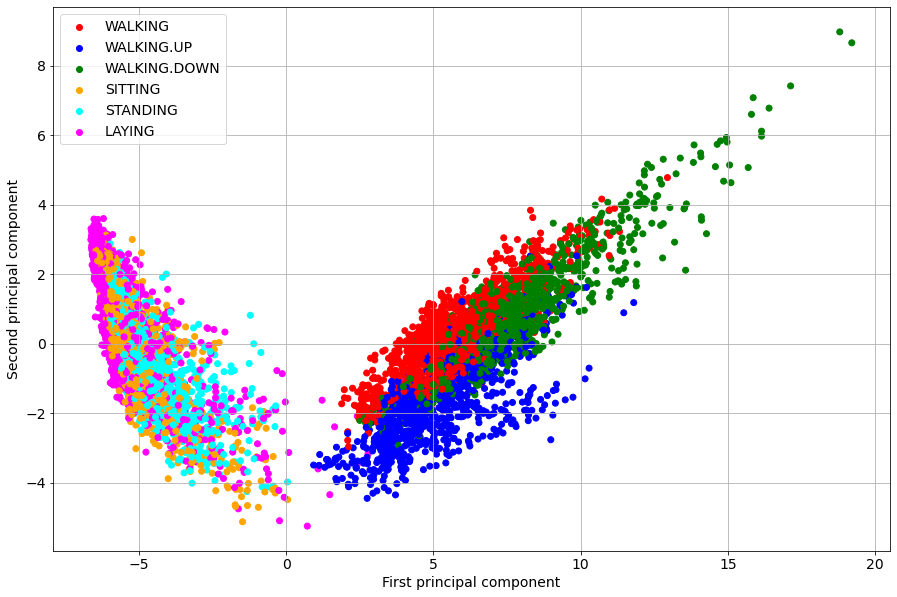

In [5]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [0]:
from tqdm.notebook import tqdm

In [9]:
%%time
X_train_new = np.array([])
for x in tqdm(X_train):
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L10 = SSA(t, 17)
        if len(a) != 0:
            a = np.append(a, F_ssa_L10.Sigma, axis=0)
        else:
            a = F_ssa_L10.Sigma
    if len(X_train_new) != 0:
        X_train_new = np.append(X_train_new, a, axis=0)
    else:
        X_train_new = a


CPU times: user 46min 45s, sys: 33min 18s, total: 1h 20min 3s
Wall time: 41min 20s


In [10]:
%%time
X_test_new = np.array([])
for x in tqdm(X_test):
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L10 = SSA(t, 17)
        if len(a) != 0:
            a = np.append(a, F_ssa_L10.Sigma, axis=0)
        else:
            a = F_ssa_L10.Sigma
    if len(X_test_new) != 0:
        X_test_new = np.append(X_test_new, a, axis=0)
    else:
        X_test_new = a


CPU times: user 18min 30s, sys: 13min 8s, total: 31min 38s
Wall time: 16min 21s


In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from keras.utils import np_utils

In [0]:
def get_all_results(model, parameters, x_train, y_train, x_test, y_test):
    gridsearch = GridSearchCV(model(), parameters, n_jobs=2)
    gridsearch.fit(X_train_new, y_train_new)
    print(gridsearch.best_params_)
    
    params = dict(gridsearch.best_params_)
    clf = model(**params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    
    classifier = OneVsRestClassifier(model(**params))
    try:
        y_score = classifier.fit(X_train_new, Y_train_new).decision_function(X_test_new)
    except:
        y_score = clf.predict_proba(X_test_new)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Plot all ROC curves
    plt.figure(figsize=(13,10))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + str(clf).split('(')[0])
    plt.legend(loc="lower right")
    plt.show()

In [0]:
X_train_new = X_train_new.reshape(7352, -1)
X_train_new = X_train_new.astype('float32')
X_train_new /= np.amax(X_train_new)
y_train_new = y_train.reshape(-1)
Y_train_new = np_utils.to_categorical(y_train, 6)

In [22]:
X_train_new.shape

(7352, 153)

In [0]:
X_test_new = X_test_new.reshape(X_test.shape[0], -1)
X_test_new = X_test_new.astype('float32')
X_test_new /= np.amax(X_test_new)
y_test_new = y_test.reshape(-1)
Y_test_new = np_utils.to_categorical(y_test_new, 6)

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
def build_model():
    model = Sequential()
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [0]:
keras_model = build_model()

In [28]:
%%time
history = keras_model.fit(X_train_new, Y_train_new, epochs=100, validation_split=0.1, batch_size=512, shuffle=True)

Epoch 1/100
13/13 [==============================] - 1s 40ms/step - loss: 1.7884 - accuracy: 0.1904 - val_loss: 1.7858 - val_accuracy: 0.1685
Epoch 2/100
13/13 [==============================] - 0s 21ms/step - loss: 1.7564 - accuracy: 0.2278 - val_loss: 1.6736 - val_accuracy: 0.5149
Epoch 3/100
13/13 [==============================] - 0s 22ms/step - loss: 1.5226 - accuracy: 0.3278 - val_loss: 1.2841 - val_accuracy: 0.3614
Epoch 4/100
13/13 [==============================] - 0s 22ms/step - loss: 1.2661 - accuracy: 0.3475 - val_loss: 1.1105 - val_accuracy: 0.3492
Epoch 5/100
13/13 [==============================] - 0s 21ms/step - loss: 1.1731 - accuracy: 0.3575 - val_loss: 1.1356 - val_accuracy: 0.3655
Epoch 6/100
13/13 [==============================] - 0s 21ms/step - loss: 1.1586 - accuracy: 0.3478 - val_loss: 1.1034 - val_accuracy: 0.3220
Epoch 7/100
13/13 [==============================] - 0s 21ms/step - loss: 1.1491 - accuracy: 0.3593 - val_loss: 1.1135 - val_accuracy: 0.4185
Epoch 

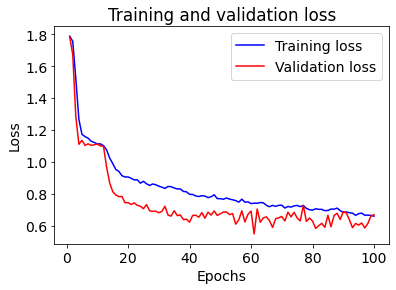

<Figure size 1080x720 with 0 Axes>

In [29]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 101)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure(figsize=(15,10))
plt.show()

In [31]:
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             multiple                  15400     
_________________________________________________________________
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  10100     
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  10100     
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
dense_13 (Dense)             multiple                 

In [34]:
predictions= keras_model.predict(X_test_new)
y_pred = [np.argmax(x) for x in predictions]
y_test = y_test.reshape(-1)
(y_pred == y_test).mean()

0.7397353240583644

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       496
           1       0.76      0.90      0.83       471
           2       0.73      0.64      0.68       420
           3       0.68      0.61      0.64       491
           4       0.60      0.81      0.69       532
           5       0.89      0.65      0.75       537

    accuracy                           0.74      2947
   macro avg       0.75      0.74      0.74      2947
weighted avg       0.75      0.74      0.74      2947



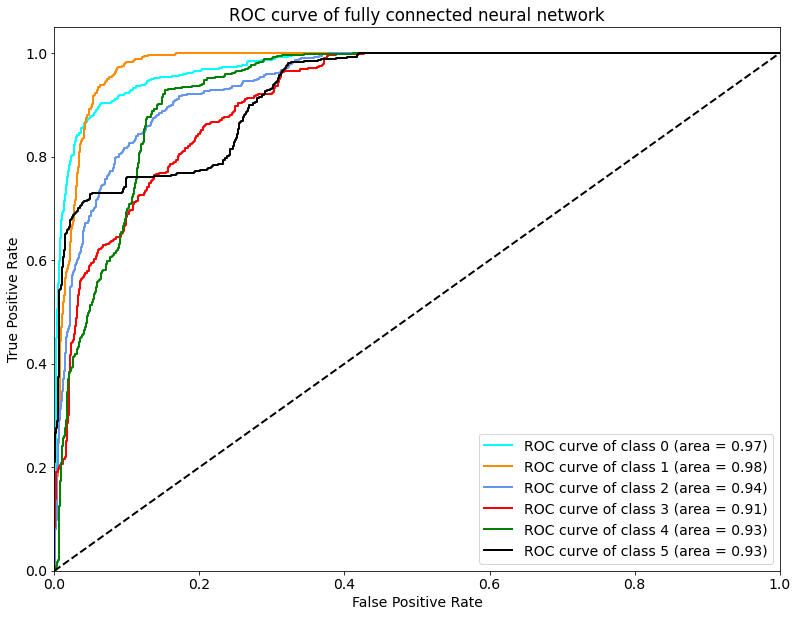

In [36]:
y_score = keras_model.predict(X_test_new)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(13,10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of fully connected neural network')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting Classifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

{'learning_rate': 0.1, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.35      0.73      0.47       496
           1       0.73      0.79      0.76       471
           2       0.62      0.80      0.70       420
           3       0.38      0.27      0.32       491
           4       0.23      0.05      0.08       532
           5       0.86      0.61      0.71       537

    accuracy                           0.53      2947
   macro avg       0.53      0.54      0.51      2947
weighted avg       0.52      0.53      0.50      2947



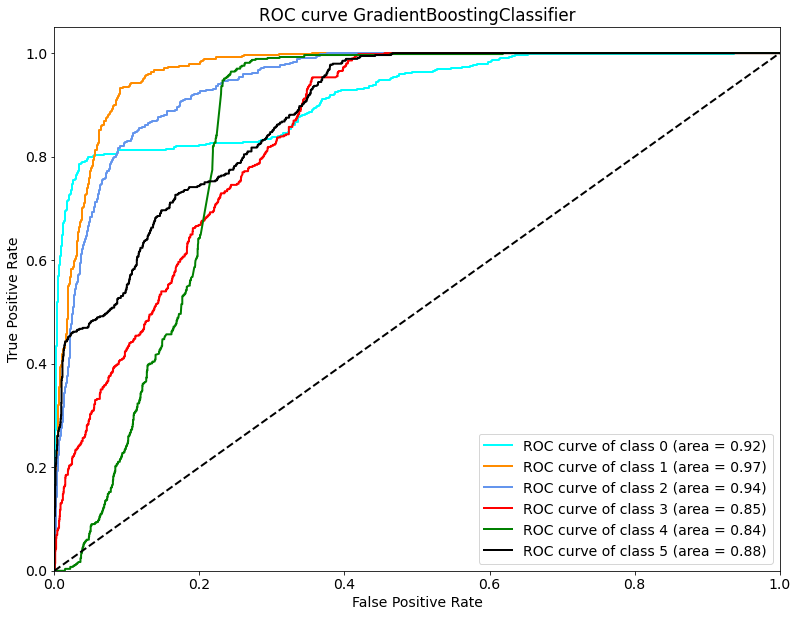

CPU times: user 18min 6s, sys: 492 ms, total: 18min 6s
Wall time: 2h 1min 52s


In [0]:
%%time
parameters = {'learning_rate': [0.02, 0.05, 0.1], 'n_estimators': [50, 100, 150]}
get_all_results(GradientBoostingClassifier, parameters, X_train_new, y_train_new,
                X_test_new, y_test_new)

# SVM

{'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.28      0.81      0.42       496
           1       0.46      0.86      0.60       471
           2       0.74      0.76      0.75       420
           3       0.15      0.05      0.08       491
           4       0.00      0.00      0.00       532
           5       0.83      0.01      0.02       537

    accuracy                           0.39      2947
   macro avg       0.41      0.42      0.31      2947
weighted avg       0.40      0.39      0.29      2947



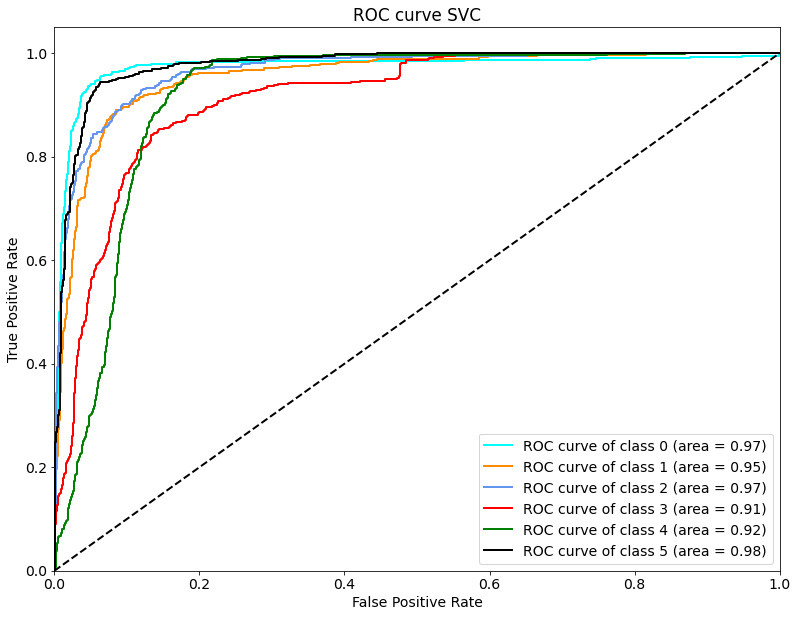

CPU times: user 37.5 s, sys: 225 ms, total: 37.7 s
Wall time: 2min 8s


In [0]:
%%time
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
get_all_results(SVC, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# KNeighborsClassifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'algorithm': 'ball_tree', 'n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.49      0.92      0.64       496
           1       0.79      0.52      0.63       471
           2       0.77      0.60      0.67       420
           3       0.35      0.52      0.42       491
           4       0.23      0.08      0.12       532
           5       0.62      0.55      0.58       537

    accuracy                           0.52      2947
   macro avg       0.54      0.53      0.51      2947
weighted avg       0.53      0.52      0.50      2947



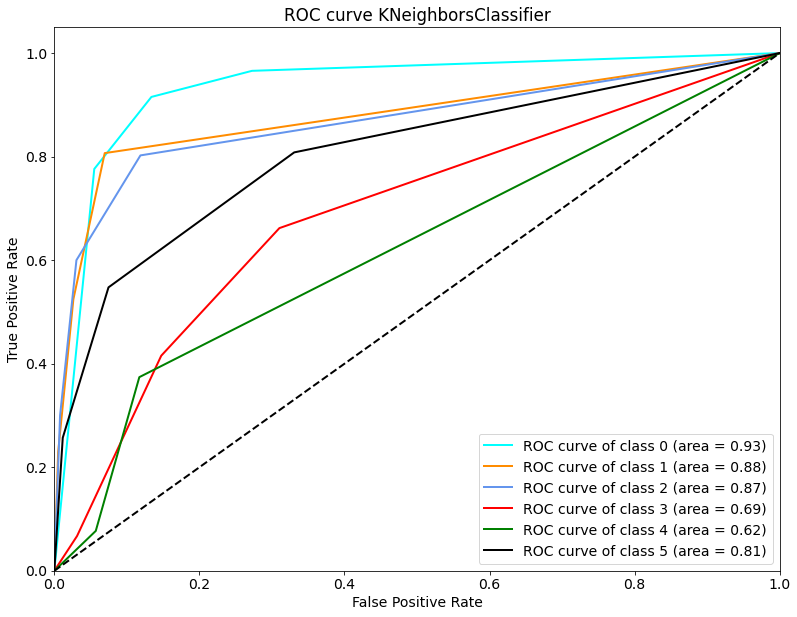

CPU times: user 9.43 s, sys: 74.5 ms, total: 9.5 s
Wall time: 53.9 s


In [0]:
%%time
parameters = {'n_neighbors': [3, 5, 7, 10], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
get_all_results(KNeighborsClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

{'bootstrap': False, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       496
           1       0.76      0.76      0.76       471
           2       0.55      0.81      0.65       420
           3       0.52      0.34      0.42       491
           4       0.43      0.02      0.04       532
           5       0.37      0.84      0.52       537

    accuracy                           0.55      2947
   macro avg       0.60      0.56      0.52      2947
weighted avg       0.59      0.55      0.51      2947



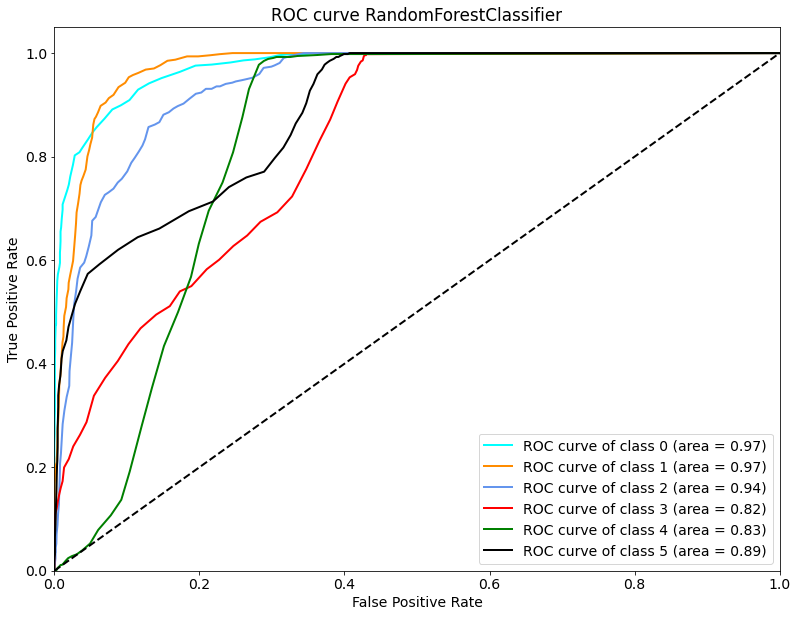

CPU times: user 1min 15s, sys: 70.1 ms, total: 1min 15s
Wall time: 5min 44s


In [0]:
%%time
parameters = {'n_estimators': [100, 150, 200], 'bootstrap': [True, False]}
get_all_results(RandomForestClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# AdaBoostClassifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier

{'learning_rate': 1.0, 'n_estimators': 150}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.36      1.00      0.53       496
           1       0.53      0.07      0.12       471
           2       0.00      0.00      0.00       420
           3       0.32      0.99      0.49       491
           4       0.56      0.02      0.03       532
           5       0.35      0.01      0.02       537

    accuracy                           0.35      2947
   macro avg       0.36      0.35      0.20      2947
weighted avg       0.37      0.35      0.20      2947



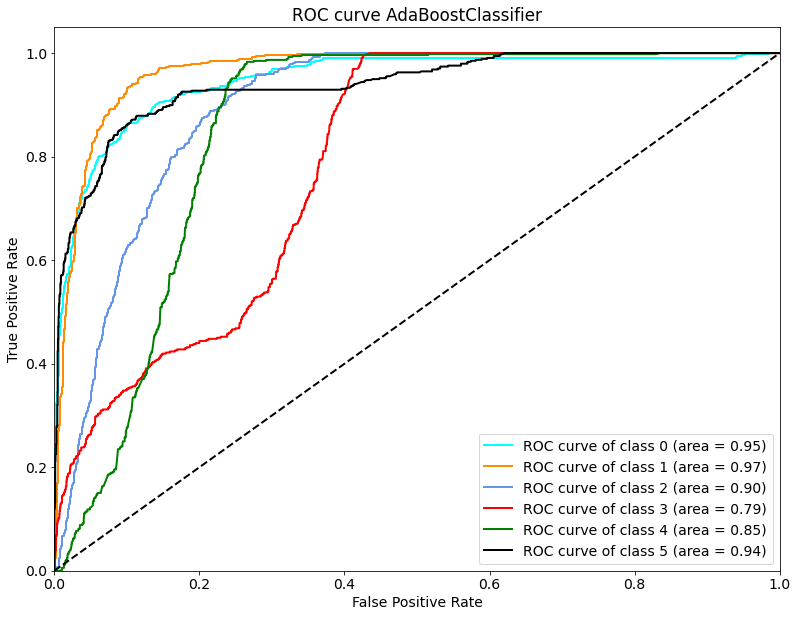

CPU times: user 3min 5s, sys: 89.1 ms, total: 3min 5s
Wall time: 17min 36s


In [0]:
%%time
parameters = {'n_estimators': [50, 100, 150, 200], 'learning_rate': [1.0, 1.2, 1.5, 2.0]}
get_all_results(AdaBoostClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# SGD

In [0]:
from sklearn.linear_model import SGDClassifier

{'eta0': 0.5, 'learning_rate': 'adaptive', 'penalty': 'l1', 'shuffle': True}
              precision    recall  f1-score   support

           0       0.87      0.46      0.61       496
           1       0.37      0.89      0.52       471
           2       0.45      0.60      0.51       420
           3       0.72      0.35      0.47       491
           4       0.57      0.79      0.66       532
           5       0.90      0.02      0.03       537

    accuracy                           0.51      2947
   macro avg       0.65      0.52      0.47      2947
weighted avg       0.66      0.51      0.46      2947



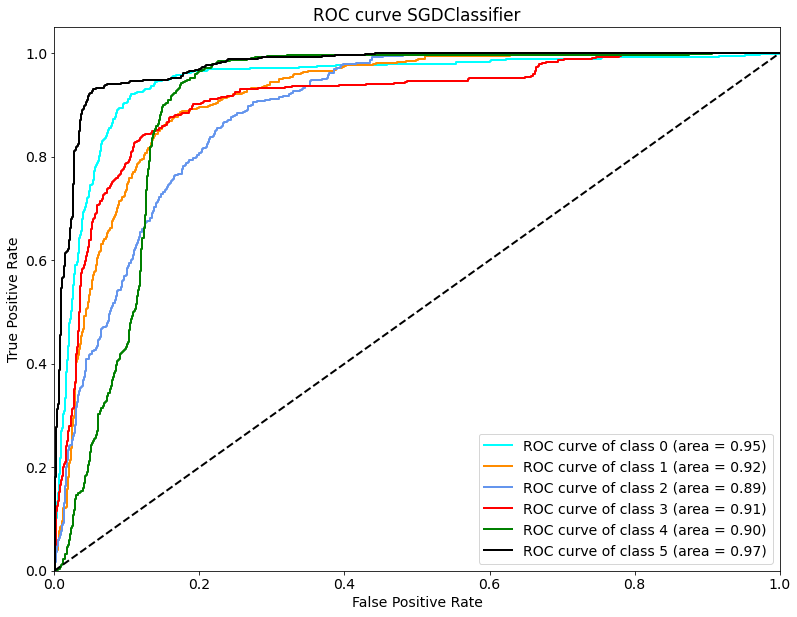

CPU times: user 9.64 s, sys: 209 ms, total: 9.85 s
Wall time: 1min 17s


In [0]:
%%time
parameters = {'penalty': ['l2', 'l1'], 'shuffle': [True, False],
              'learning_rate': ['optimal', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.5]}
get_all_results(SGDClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# HistGradientBoostingClassifier

In [0]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'l2_regularization': 0, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       496
           1       0.81      0.85      0.83       471
           2       0.68      0.80      0.73       420
           3       0.46      0.34      0.39       491
           4       0.07      0.01      0.02       532
           5       0.40      0.81      0.54       537

    accuracy                           0.58      2947
   macro avg       0.55      0.59      0.56      2947
weighted avg       0.54      0.58      0.54      2947



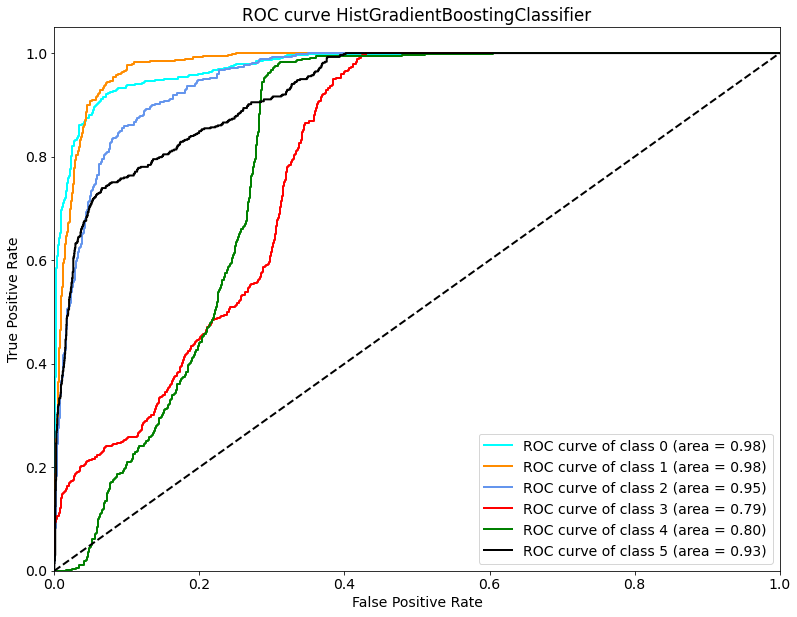

CPU times: user 2min 5s, sys: 13.1 s, total: 2min 18s
Wall time: 10min 6s


In [0]:
%%time
parameters = {'learning_rate': [0.1, 0.05, 0.01, 0.5],
              'l2_regularization': [0, 1]}
get_all_results(HistGradientBoostingClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)